1. Carga de datos y librerias

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [89]:
# Cargar el dataset
df = pd.read_csv("../../data/youtoxic_english_1000.csv", encoding="utf-8")
print("Dataset cargado exitosamente!")
print(f"Forma del dataset: {df.shape}")
df.head()
df.info()
df.describe()

Dataset cargado exitosamente!
Forma del dataset: (1000, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsHatespeech     1000 non-null   bool  
 9   IsRacist         1000 non-null   bool  
 10  IsNationalist    1000 non-null   bool  
 11  IsSexist         1000 non-null   bool  
 12  IsHomophobic     1000 non-null   bool  
 13  IsReligiousHate  1000 non-null   bool  
 14  IsRadicalism     1000 non-null   bool  
dtypes: bool(12), object(3)
memory usage: 35.3+ KB


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,13,997,2,2,2,2,2,2,2,2,2,1,2,1
top,Ugg2KwwX0V8-aXgCoAEC,9pr1oE34bIM,run them over,False,False,False,False,False,False,False,False,False,False,False,False
freq,1,274,3,538,647,979,839,900,862,875,992,999,1000,988,1000


2. Revisar datos faltantes

In [90]:
df.isnull().sum()


CommentId          0
VideoId            0
Text               0
IsToxic            0
IsAbusive          0
IsThreat           0
IsProvocative      0
IsObscene          0
IsHatespeech       0
IsRacist           0
IsNationalist      0
IsSexist           0
IsHomophobic       0
IsReligiousHate    0
IsRadicalism       0
dtype: int64

In [91]:
# Si hay comentarios vacíos, conviene eliminarlos:
df = df.dropna(subset=["CommentId"])


3. Revisar distribución de las clases

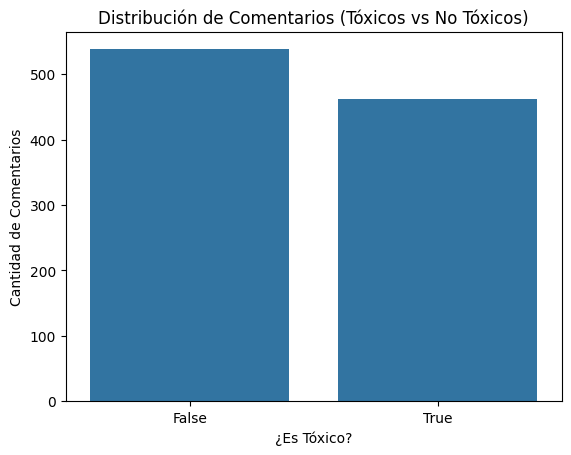

In [92]:
sns.countplot(x="IsToxic", data=df)
plt.title("Distribución de Comentarios (Tóxicos vs No Tóxicos)")
plt.xlabel("¿Es Tóxico?")
plt.ylabel("Cantidad de Comentarios")
plt.show()

4. Normalización

In [93]:
import re
import emoji
import unicodedata


In [94]:
def clean_text(text):
    # Asegurar que sea string y pasar a minúsculas
    text = str(text).lower()
    
    # Codificación segura en UTF-8
    text = text.encode("utf-8", "ignore").decode("utf-8")
    
    # Convertir emojis a texto (ej. 😂 -> :cara_llorando_de_risa:)
    text = emoji.demojize(text, language='es')
    
    # Eliminar URLs
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    
    # Eliminar menciones y hashtags
    text = re.sub(r"@\w+|#\w+", " ", text)
    
    # Quitar caracteres raros (manteniendo letras, tildes, ñ, ü y :)
    text = re.sub(r"[^a-záéíóúñü\s:]", " ", text)
    
    # Normalizar espacios múltiples
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# Aplicar la función de limpieza a la columna Text
df["text_clean"] = df["Text"].apply(clean_text)
print("Texto limpiado exitosamente!")
print("Ejemplo de texto original vs limpio:")
print(f"Original: {df['Text'].iloc[0][:100]}...")
print(f"Limpio: {df['text_clean'].iloc[0][:100]}...")

Texto limpiado exitosamente!
Ejemplo de texto original vs limpio:
Original: If only people would just take a step back and not make this case about them, because it wasn't abou...
Limpio: if only people would just take a step back and not make this case about them because it wasn t about...


5. Longitud de comentarios

count    1000.000000
mean       34.142000
std        49.098478
min         0.000000
25%         9.000000
50%        19.000000
75%        40.000000
max       810.000000
Name: length, dtype: float64


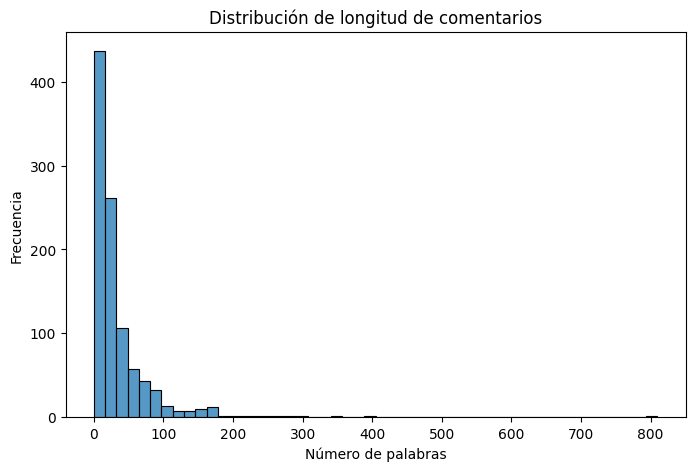

In [95]:
df["length"] = df["text_clean"].apply(lambda x: len(x.split()))
print(df["length"].describe())

plt.figure(figsize=(8,5))
sns.histplot(df["length"], bins=50, kde=False)
plt.title("Distribución de longitud de comentarios")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()



In [ ]:
# 6. Procesamiento avanzado con spaCy
import spacy
 
# Descargar modelo en inglés
# !python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

def limpiar_con_spacy(texto):
    doc = nlp(texto)
    # Eliminar stopwords y puntuación
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

df['texto_procesado'] = df['text_clean'].apply(limpiar_con_spacy)
print("Texto procesado con spaCy exitosamente!")
print(f"Ejemplo: {df['texto_procesado'].iloc[0][:100]}...")



Texto procesado con spaCy exitosamente!
Ejemplo: people step case wasn t people situation lump mess matter hand make kind protest selfish rational th...


6. Palabras más frecuentes


In [97]:
from collections import Counter

def get_top_words(texts, n=20):
    all_words = " ".join(texts).split()
    return Counter(all_words).most_common(n)

print("Top palabras en comentarios TÓXICOS:")
print(get_top_words(df[df["IsToxic"]==True]["texto_procesado"]))

print("\nTop palabras en comentarios NO TÓXICOS:")
print(get_top_words(df[df["IsToxic"]==False]["texto_procesado"]))


Top palabras en comentarios TÓXICOS:
[('black', 165), ('people', 131), ('t', 118), ('s', 112), ('white', 98), ('shoot', 79), ('fuck', 76), ('like', 75), ('police', 75), ('cop', 69), ('brown', 56), ('get', 48), ('shit', 46), ('officer', 45), ('kill', 44), ('don', 44), ('guy', 43), ('run', 43), ('racist', 38), ('man', 38)]

Top palabras en comentarios NO TÓXICOS:
[('black', 148), ('people', 131), ('t', 121), ('police', 104), ('s', 102), ('cop', 83), ('like', 80), ('officer', 75), ('white', 72), ('video', 70), ('shoot', 58), ('brown', 58), ('know', 52), ('say', 50), ('time', 43), ('don', 43), ('go', 42), ('need', 40), ('man', 40), ('think', 39)]


7. Wordcloud por clase